In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-deep')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('day.csv')

## EDA

In [3]:
df.shape

(730, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


##### Observation:
1. There are no nulls
2. All the features have correct datatypes

In [5]:
df.head(15)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,6,0,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,0,0,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,1,1,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,2,1,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,3,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


##### Transformations to perform
1. drop instant columns as it is just an index
2. extract day from dteday, we have yr and month already capturing the year and info respectively
3. replace encoded values season, weathersit, weekday
4. We will have to group weekdays and months based on the average demand for better encoding in model building

- We will not decode yr column and consider 0 as 2018 and 1 as 2019.
- From the data it is evident that 0 is Sunday and 6 is Saturday as workingday value is 0.
- Idea is to predict casual and registered so as to finally calculate cnt: cnt = casual + registered

In [6]:
#drop unnecessary columns
df.drop(['instant'],axis=1,inplace=True)

In [7]:
#extract day from date
df['day'] = pd.DatetimeIndex(df['dteday']).day

#extract month name for better understanding
df['month'] = pd.DatetimeIndex(df['dteday']).month_name()

#drop date column
df.drop(['dteday','mnth'],axis=1,inplace=True)

#we will consider 2018 as 0 and 2019 as 1

In [8]:
#decode the weathersit column
df[['weathersit']] = df[['weathersit']].apply(lambda x: x.map({1:'Clear+Cloudy',2:'Mist+Cloudy',3:'Snow+Rain',4:'Severe weather'}))

#decode the seaon column
df[['season']] = df[['season']].apply(lambda x: x.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'}))

df[['weekday']] = df[['weekday']].apply(lambda x: x.map({0:'sunday', 1 :'monday', 2:'tuesday', 3:'wednesday', 4:'thursday',5:'friday',6:'saturday'}))

In [9]:
df.head()

,season,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,month
0,spring,0,0,monday,1,Mist+Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,January
1,spring,0,0,tuesday,1,Mist+Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,1,February
2,spring,0,0,wednesday,1,Clear+Cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,March
3,spring,0,0,thursday,1,Clear+Cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,April
4,spring,0,0,friday,1,Clear+Cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,May


### Visualize categorical data

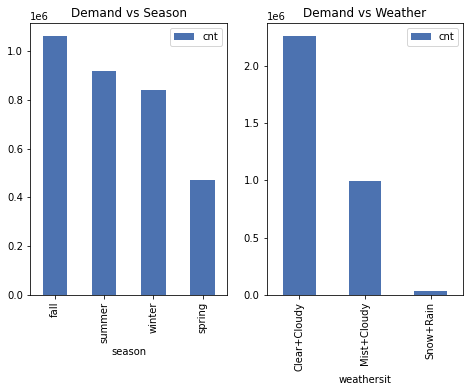

In [10]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 3, 1, title="Demand vs Season")
ax2 = fig.add_subplot(1, 3, 2, title="Demand vs Weather")

df.groupby('season').sum().sort_values('cnt', ascending=False)[['cnt']].plot.bar(ax=ax1)
df.groupby('weathersit').sum().sort_values('cnt', ascending=False)[['cnt']].plot.bar(ax=ax2)


plt.show()

In [11]:
df[df.weathersit =='Severe weather']

,season,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,month


##### Observations:
- People are most likely to rent bikes in 'fall' and least likely to rent shared bikes in 'spring'
- Highest demand of shared bikes is in 'Clear+Cloudy' weather whereas Least demand is in 'Snow+Rain'
- As expected there is no demand in 'severe weather'

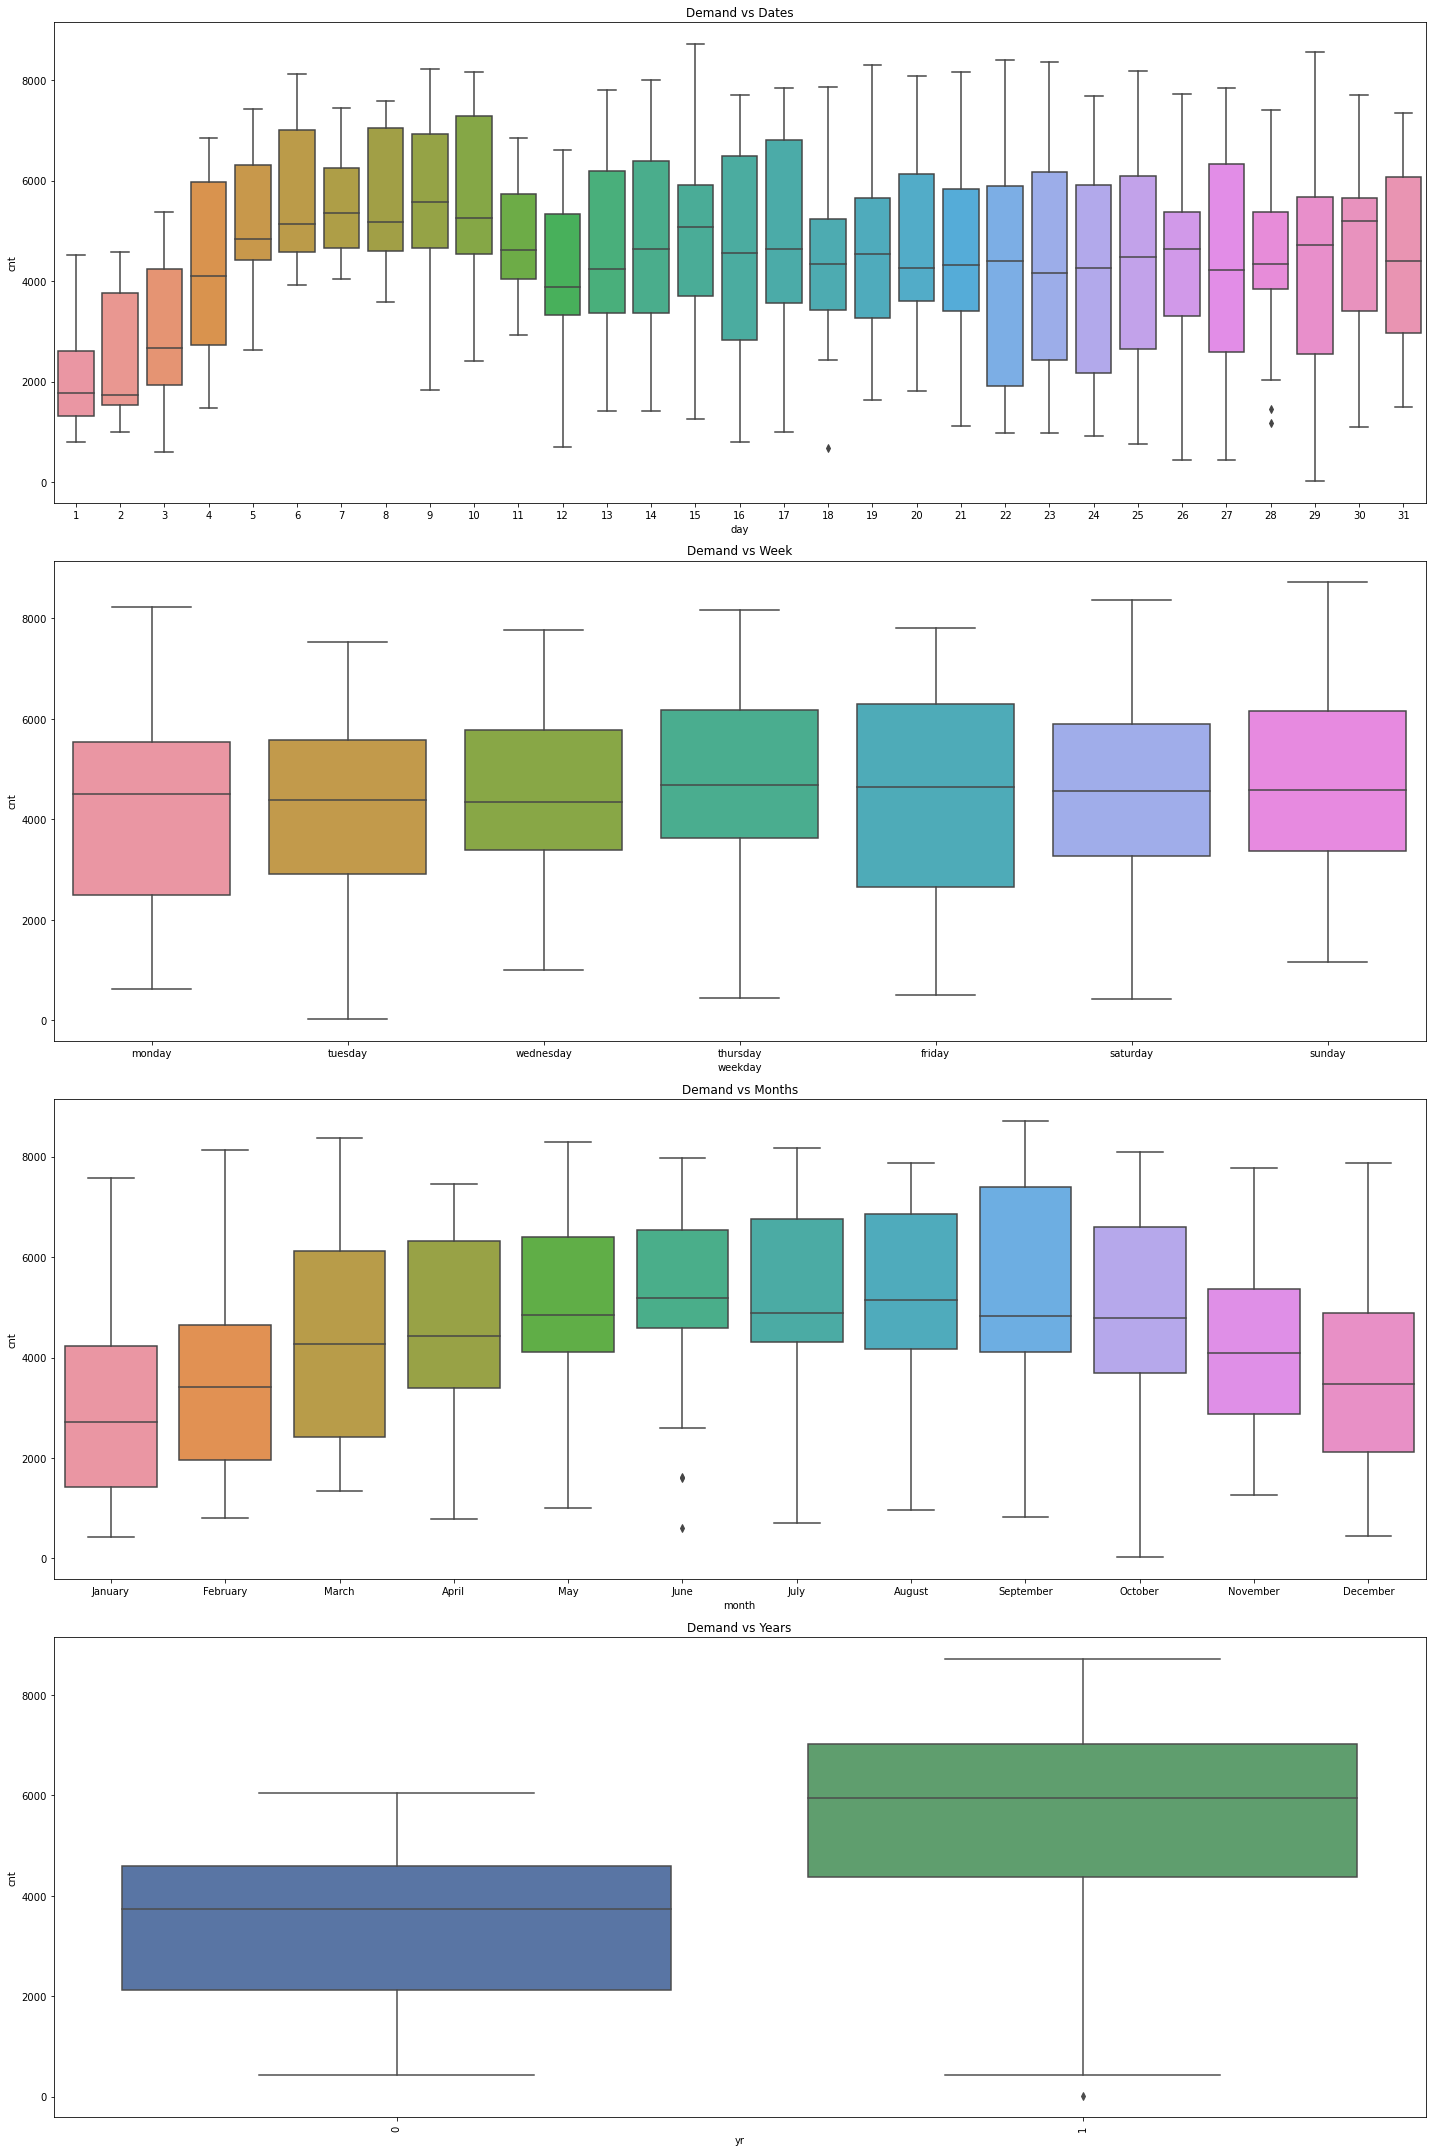

In [12]:
fig = plt.figure(figsize=(20,30))

ax1 = fig.add_subplot(4, 1, 1, title="Demand vs Dates")
ax2 = fig.add_subplot(4, 1, 2, title="Demand vs Week")
ax3 = fig.add_subplot(4, 1, 3, title="Demand vs Months")
ax4 = fig.add_subplot(4, 1, 4, title="Demand vs Years")

sns.boxplot(df['day'], df['cnt'], ax=ax1)
sns.boxplot(df['weekday'], df['cnt'], ax=ax2)
sns.boxplot(df['month'], df['cnt'], ax=ax3)
sns.boxplot(df['yr'], df['cnt'], ax=ax4)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Observation
- Dates between 5 to 10 show increase in demand. This could be because of factors such as paydays, offers, holidays.
- As expected shared bike demand is higher on Satuday and Sunday than weekdays
- Deman of shared bikes increases towards August and then dips again
- Demand of share bikes increased in 2019 from previous year.
- The outliers are expected as they could be the scenario of number of bikes rented on 'Snow+Rain' days


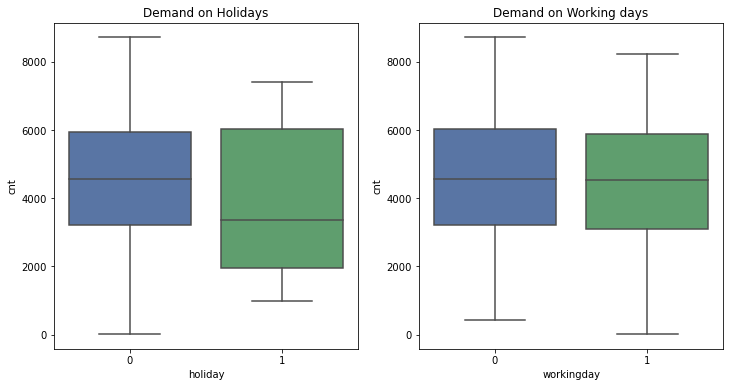

In [13]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Demand on Holidays")
ax2 = fig.add_subplot(1, 2, 2, title="Demand on Working days")

sns.boxplot(df['holiday'], df['cnt'], ax=ax1)
sns.boxplot(df['workingday'], df['cnt'], ax=ax2)

plt.show()

- Bike demand is similar for both working day or non-working day
- Working day has slightly less demand
- We can see more swing in demand of bikes on non-holiday

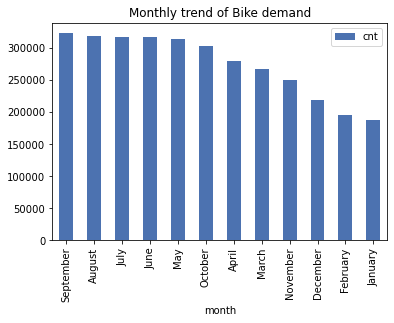

In [14]:
df.groupby('month').sum().sort_values('cnt', ascending=False)[['cnt']].plot.bar()
plt.title("Monthly trend of Bike demand")
plt.show()

##### Observation:
- We can see that there is a monthly trend for bike demand.
- We can club the months with similar demands for better model building.

##### Encoding month columns
- group1(Sepetember,August,July) : sep_aug_jul (Highest bike demand)
- group2(June,May,October): jun_may_oct
- group3(April, March, November): apr_mar_nov
- group4(December, February, January) (Lowest bike demand) While encoding, 0 is all other columns would signify group 4

In [15]:
df["sep_aug_jul"] = df["month"].apply(lambda x : 1 if x in ["July","August","September"] else 0)
df["jun_may_oct"] = df["month"].apply(lambda x : 1 if x in ["May","June","October"] else 0)
df["apr_mar_nov"] = df["month"].apply(lambda x : 1 if x in ["March","April","November"] else 0)

In [16]:
df.drop(['month'],axis=1,inplace=True)

#### Creating dummy variables for categorical columns:
1. Season
2. Weekday
3. Weathersit

In [17]:
def dummies(df, feature):
    dummy_df = pd.get_dummies(df[feature], drop_first='True')
    df.drop(feature, axis=1, inplace=True)
    return pd.concat([df,dummy_df], axis=1)

In [18]:
df = dummies(df,'season')
df = dummies(df,'weekday')
df = dummies(df,'weathersit')

In [19]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,summer,winter,monday,saturday,sunday,thursday,tuesday,wednesday,Mist+Cloudy,Snow+Rain
0,0,0,1,14.110847,18.18125,80.5833,10.749882,331,654,985,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,131,670,801,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,0,0,0,0,0,0,0,0,0,0


### Visualize numeric data

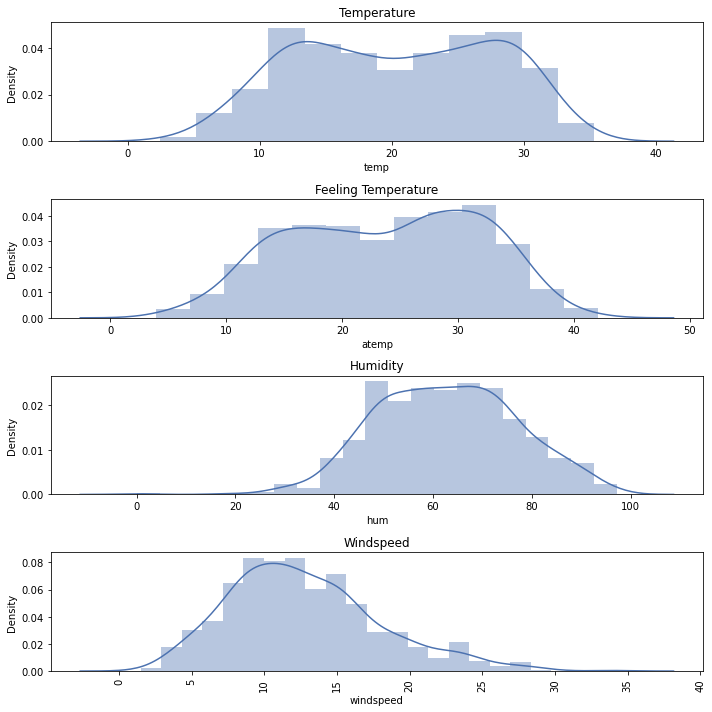

In [20]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(4, 1, 1, title="Temperature")
ax2 = fig.add_subplot(4, 1, 2, title="Feeling Temperature")
ax3 = fig.add_subplot(4, 1, 3, title="Humidity")
ax4 = fig.add_subplot(4, 1, 4, title="Windspeed")

sns.distplot(df['temp'], ax=ax1)
sns.distplot(df['atemp'], ax=ax2)
sns.distplot(df['hum'], ax=ax3)
sns.distplot(df['windspeed'], ax=ax4)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- We can see fairly normal disribution in humidity and windspeed data

In [21]:
#save numeric features in a list
num_vars = ['temp','atemp','hum','windspeed','casual','registered','cnt']

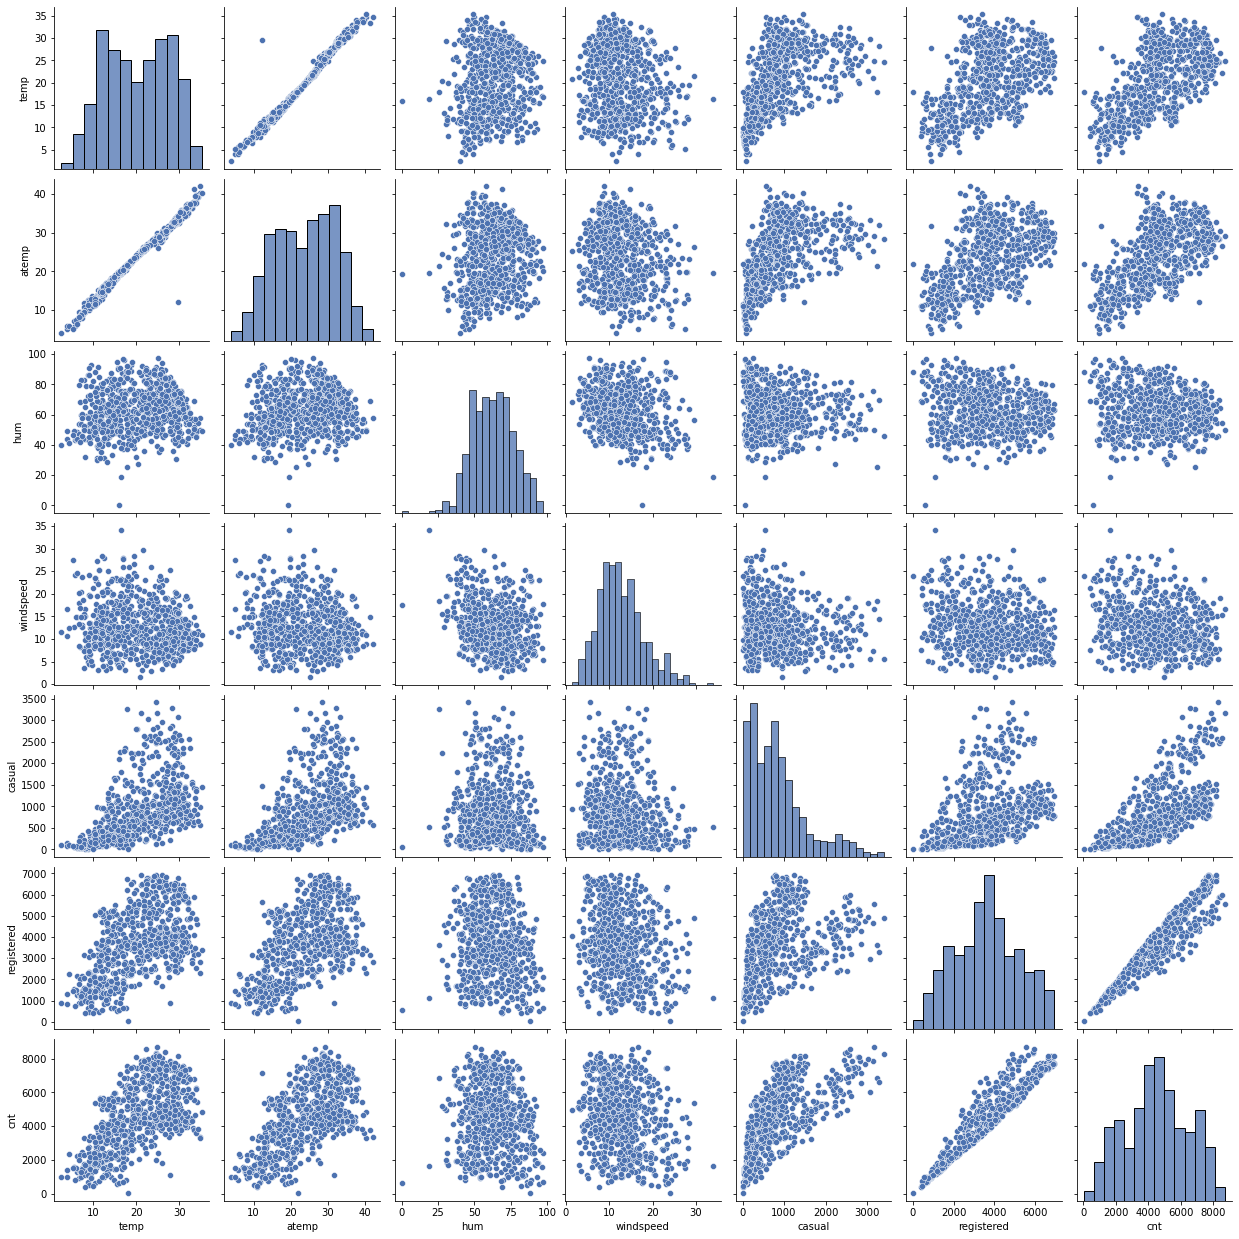

In [22]:
#visualize the association of features with target variable
sns.pairplot(df[num_vars])

<AxesSubplot:>

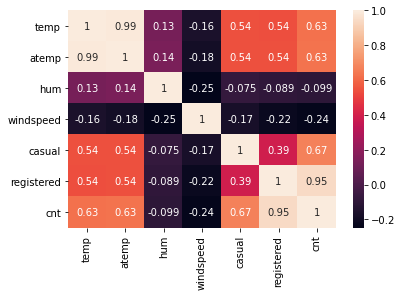

In [23]:
sns.heatmap(df[num_vars].corr(),annot=True)

##### Observations:
- We can see strong correlation between temp and atemp. This can point to multicollinearity
- Target variable 'cnt' has high correlation with registered. but as casual+registered = cnt we can drop these two columns

In [24]:
df.drop(['casual','registered'],axis=1, inplace=True)

In [25]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,day,sep_aug_jul,...,summer,winter,monday,saturday,sunday,thursday,tuesday,wednesday,Mist+Cloudy,Snow+Rain
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#store numeric predictors in a list
num_predictors = ['temp','atemp','hum','windspeed']

In [27]:
df[num_predictors].describe()

,temp,atemp,hum,windspeed
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620
std,7.506729,8.150308,14.237589,5.195841
min,2.424346,3.953480,0.000000,1.500244
25%,13.811885,16.889713,52.000000,9.041650
50%,20.465826,24.368225,62.625000,12.125325
75%,26.880615,30.445775,72.989575,15.625589
max,35.328347,42.044800,97.250000,34.000021


### Train-Test Split

In [28]:


#split dataframe into 70%-30%(train-test)
df_train, df_test = train_test_split(df, train_size=0.7,random_state=100)

### Rescaling numeric features in training dataset

In [29]:


#instantiate a scaler object to train on train dataset
scaler = MinMaxScaler()

df_train[num_predictors] = scaler.fit_transform(df_train[num_predictors])

In [30]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,day,sep_aug_jul,...,summer,winter,monday,saturday,sunday,thursday,tuesday,wednesday,Mist+Cloudy,Snow+Rain
576,1,0,1,0.815169,0.766351,0.725633,0.264686,7216,31,1,...,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,4066,3,0,...,0,0,0,0,1,0,0,0,1,0
728,1,0,1,0.245101,0.200348,0.498067,0.663106,1796,30,0,...,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,4220,28,0,...,1,0,0,0,1,0,0,0,1,0
111,0,0,0,0.345824,0.318819,0.751824,0.380981,1683,22,0,...,1,0,0,0,1,0,0,0,1,0


In [31]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,day,sep_aug_jul,...,summer,winter,monday,saturday,sunday,thursday,tuesday,wednesday,Mist+Cloudy,Snow+Rain
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.711765,0.537440,0.513156,0.650480,0.320883,4485.337255,15.631373,0.237255,...,0.247059,0.247059,0.154902,0.129412,0.137255,0.143137,0.152941,0.135294,0.345098,0.029412
std,0.500429,0.157763,0.453386,0.225858,0.212410,0.145846,0.169803,1950.666077,8.852724,0.425818,...,0.431725,0.431725,0.362166,0.335985,0.344454,0.350557,0.360284,0.342373,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,3120.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,4530.000000,16.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,5973.500000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8714.000000,31.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building model

In [32]:
#split the data into dependant and independant variables
y_train = df_train.pop('cnt')
X_train = df_train

##### Building a model with all features

In [33]:
#Beacuse we are using statsmodel to build a model we will add a constant
X_train_sm = sm.add_constant(X_train)

lm = sm.OLS(y_train,X_train_sm).fit()
print(lm.summary())
#############################

#check the Variance Inflation Factor(VIF)
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          4.39e-173
Time:                        17:22:56   Log-Likelihood:                -4131.2
No. Observations:                 510   AIC:                             8308.
Df Residuals:                     487   BIC:                             8406.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3318.9354    735.913      4.510      

#### Observations:
- When we consider all the features the R-squared value is 0.83 which means 83% variance in data is explained by out model
- prob(F-statistic) is very low which indicates an overall good fit.
- However we can see that for few features they aren't significant as p-value is more than 0.05
- Also the Variance Inflation Factor for a few columns is greater than 5 which is not acceptable and hints towards multicollinearity.

##### Using hybrid approach to select features
- Use Recursive Featire Elimination(RFE) for coarse feature selection
- Use manual approach for fine feature tuning

In [34]:
#fit a LR on all features from X_train and pass the number of features expected in RFE()
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,20)
rfe = rfe.fit(X_train, y_train)

#Save top 20 features in a list
top_20 = X_train.columns[rfe.support_]

#Using statsmodel for summary
X_train_rfe = X_train[top_20]
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     121.4
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          4.79e-175
Time:                        17:22:59   Log-Likelihood:                -4131.5
No. Observations:                 510   AIC:                             8305.
Df Residuals:                     489   BIC:                             8394.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3282.7539    728.787      4.504      0.000    1850.813    4714.695
yr           2002.2014     73.661     27.181      0.000    1857.470    2146.933
holiday     -1326.2059    591.327     -2.243      0.025   -2488.060    -164.352
workingday   -757.2433    644.852     -1.174      0.241   -2024.265     509.779
temp         3761.5249   1228.390      3.062      0.002    1347.951    6175.099
atemp         466.8882   1250.679      0.373      0.709   -1990.480    2924.256
hum         -1170.5277    341.239     -3.430      0.001   -1841.004    -500.051
windspeed   -1526.7490    238.347     -6.406      0.000   -1995.059   -1058.439
sep_aug_jul   205.6501    120.195      1.711      0.088     -30.512     441.812
jun_may_oct   139.1857    113.781      1.223      0.222     -84.373     362.745
apr_mar_nov   123.8563    109.543      1.131      0.259     -91.376     339.089
spring       -606.8831    187.506     -3.237      0.001    -975.300    -238.466
summer        394.7640    133.881      2.949      0.003     131.712     657.816
winter        792.9713    157.754      5.027      0.000     483.012    1102.931
monday       -254.3890    113.918     -2.233      0.026    -478.217     -30.561
saturday     -726.1136    647.332     -1.122      0.263   -1998.008     545.781
sunday       -687.0086    647.308     -1.061      0.289   -1958.858     584.841
tuesday      -268.5713    115.061     -2.334      0.020    -494.646     -42.497
wednesday    -115.0219    121.741     -0.945      0.345    -354.222     124.178
Mist+Cloudy  -479.6216     95.445     -5.025      0.000    -667.154    -292.089
Snow+Rain   -2138.7024    239.647     -8.924      0.000   -2609.567   -1667.838
==============================================================================
Omnibus:                       76.047   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.328
Skew:                          -0.753   Prob(JB):                     6.34e-43
Kurtosis:                       5.622   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# Selecting top 15 features
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,15)
rfe = rfe.fit(X_train, y_train)

#Save top 15 features in a list
top_15 = X_train.columns[rfe.support_]

#Statsmodel for summary 
X_train_rfe = X_train[top_15]
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     160.2
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          1.06e-178
Time:                        17:23:01   Log-Likelihood:                -4135.8
No. Observations:                 510   AIC:                             8304.
Df Residuals:                     494   BIC:                             8371.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3194.0508    723.386      4.415      0.000    1772.758    4615.344
yr           2005.3607     73.791     27.176      0.000    1860.377    2150.344
holiday     -1291.1360    590.403     -2.187      0.029   -2451.146    -131.126
workingday   -675.1603    641.609     -1.052      0.293   -1935.780     585.459
temp         3868.9012   1226.070      3.156      0.002    1459.947    6277.855
atemp         450.8178   1252.356      0.360      0.719   -2009.784    2911.419
hum         -1158.3046    341.558     -3.391      0.001   -1829.390    -487.219
windspeed   -1536.3655    238.448     -6.443      0.000   -2004.863   -1067.868
spring       -662.0873    181.464     -3.649      0.000   -1018.623    -305.552
summer        373.6143    123.001      3.037      0.003     131.945     615.283
winter        766.9706    150.578      5.094      0.000     471.119    1062.822
saturday     -557.0676    640.188     -0.870      0.385   -1814.895     700.760
sunday       -519.9039    640.228     -0.812      0.417   -1777.809     738.001
tuesday      -177.7090    104.645     -1.698      0.090    -383.313      27.895
Mist+Cloudy  -479.8348     95.684     -5.015      0.000    -667.832    -291.837
Snow+Rain   -2123.0260    240.039     -8.844      0.000   -2594.650   -1651.402
==============================================================================
Omnibus:                       71.764   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.671
Skew:                          -0.729   Prob(JB):                     1.18e-38
Kurtosis:                       5.469   Cond. No.                         87.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Selecting top 10 features
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,10)
rfe = rfe.fit(X_train, y_train)

#Save top 10 features in a list
top_10 = X_train.columns[rfe.support_]

X_train_rfe = X_train[top_10]
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     226.7
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          2.13e-178
Time:                        17:23:02   Log-Likelihood:                -4150.2
No. Observations:                 510   AIC:                             8322.
Df Residuals:                     499   BIC:                             8369.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3446.1909    275.243     12.521      0.000    2905.413    3986.968
yr           2033.5142     75.111     27.073      0.000    1885.941    2181.088
holiday      -824.3182    244.659     -3.369      0.001   -1305.007    -343.629
workingday   -169.9021     85.439     -1.989      0.047    -337.766      -2.038
temp         1759.4917   1165.152      1.510      0.132    -529.717    4048.701
atemp        1555.1115   1251.447      1.243      0.215    -903.643    4013.866
hum          -842.4472    341.640     -2.466      0.014   -1513.677    -171.218
windspeed   -1473.3370    238.582     -6.175      0.000   -1942.086   -1004.588
spring      -1349.4414    110.482    -12.214      0.000   -1566.508   -1132.375
Mist+Cloudy  -532.3899     97.046     -5.486      0.000    -723.059    -341.720
Snow+Rain   -2130.5379    244.576     -8.711      0.000   -2611.064   -1650.012
==============================================================================
Omnibus:                       58.491   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.603
Skew:                          -0.638   Prob(JB):                     3.22e-28
Kurtosis:                       5.081   Cond. No.                         81.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observation
- From these three model we can see that for 10 features the R-squared is the least and 20 features is the max as expected.
- But we can also see that the increase in R squared from 15 to 20 features isn't significant so we will fine tune the features for top 15

In [37]:
X_train_rfe = X_train[top_15]

X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()

print(lm.summary())

##############################
vif = pd.DataFrame()
vif['feature'] = X_train[top_15].columns
vif['vif'] = [variance_inflation_factor(X_train[top_15].values,i) for i in range(X_train[top_15].shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     160.2
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          1.06e-178
Time:                        17:23:04   Log-Likelihood:                -4135.8
No. Observations:                 510   AIC:                             8304.
Df Residuals:                     494   BIC:                             8371.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3194.0508    723.386      4.415      

In [38]:
#remove atemp as it has high VIF and high p-value
X_train = X_train[['temp','workingday','hum','sunday','saturday','windspeed','spring','winter','summer','Mist+Cloudy','yr','holiday','Snow+Rain','tuesday']]

X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_sm).fit()

print(lm.summary())
###########################
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     172.0
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          8.43e-180
Time:                        17:23:06   Log-Likelihood:                -4135.8
No. Observations:                 510   AIC:                             8302.
Df Residuals:                     495   BIC:                             8365.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3190.3504    722.677      4.415      

* Adjusted R-squared increased for above model

In [39]:
#Remove sunday as it has high p-value suggesting insignificance
X_train = X_train[['temp','workingday','hum','saturday','windspeed','spring','winter','summer','Mist+Cloudy','yr','holiday','Snow+Rain','tuesday']]

X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_sm).fit()

print(lm.summary())
######################
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     185.3
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          8.41e-181
Time:                        17:23:07   Log-Likelihood:                -4136.2
No. Observations:                 510   AIC:                             8300.
Df Residuals:                     496   BIC:                             8360.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2665.2241    319.636      8.338      

In [40]:
#Remove saturday as it has high p-value suggesting insignificance
X_train = X_train[['temp','workingday','hum','windspeed','spring','winter','summer','Mist+Cloudy','yr','holiday','Snow+Rain','tuesday']]

X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_sm).fit()

print(lm.summary())
######################
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     201.1
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          6.24e-182
Time:                        17:23:08   Log-Likelihood:                -4136.2
No. Observations:                 510   AIC:                             8298.
Df Residuals:                     497   BIC:                             8354.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2640.3926    312.665      8.445      

In [41]:
#Remove workingday as it has high p-value suggesting insignificance
X_train = X_train[['temp','hum','windspeed','spring','winter','summer','Mist+Cloudy','yr','holiday','Snow+Rain','tuesday']]

X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_sm).fit()

print(lm.summary())
###################
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     218.5
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          1.43e-182
Time:                        17:23:08   Log-Likelihood:                -4137.5
No. Observations:                 510   AIC:                             8299.
Df Residuals:                     498   BIC:                             8350.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2553.1717    308.240      8.283      

In [42]:
#remove humidity as it has high VIF
X_train = X_train[['temp','windspeed','spring','winter','summer','Mist+Cloudy','yr','holiday','Snow+Rain','tuesday']]

X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_sm).fit()

print(lm.summary())
#################
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['vif'] = round(vif['vif'],2)
vif = vif.sort_values(by = 'vif',ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     234.0
Date:                Sun, 03 Oct 2021   Prob (F-statistic):          3.08e-181
Time:                        17:23:09   Log-Likelihood:                -4143.5
No. Observations:                 510   AIC:                             8309.
Df Residuals:                     499   BIC:                             8356.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1963.5809    258.935      7.583      

### Final model

We have stepwise eliminated the features with high p-value and high VIF

In [43]:
features = ['temp','windspeed','spring','winter','summer','Mist+Cloudy','yr','holiday','Snow+Rain','tuesday']

X_train = X_train[features]
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

### Residual Analysis of Training Data

Text(0.5, 0, 'Errors')

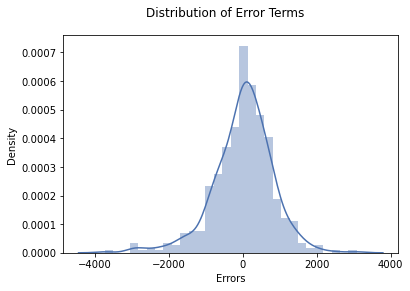

In [44]:
#make predictions on the y_train to capture residual
y_train_pred = lm.predict(X_train)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred),bins=30)
fig.suptitle('Distribution of Error Terms')
plt.xlabel('Errors')

#### Observation:

The distribution of error terms has a mean about 0 and is normally distributed

### Make predictions on test dataset

In [45]:
#Transform the numeric predictors from test dataset using the Scaler object trained earlier
df_test[num_predictors] = scaler.transform(df_test[num_predictors])

y_test = df_test.pop('cnt')
X_test = df_test

#add a constant
X_test_sm = sm.add_constant(X_test)

#remove the features from X_test that are not in the model
X_test_sm = X_test_sm[features]

In [46]:
#make predictions
y_test_pred = lm.predict(X_test_sm)

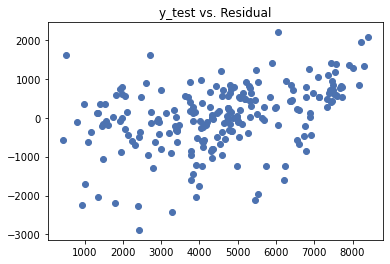

In [47]:
plt.scatter(y_test, (y_test-y_test_pred))
plt.title("y_test vs. Residual")
plt.show()

#### Observation:
The residual distribution has no visible pattern and thus residues are homoscedastic

### Model Evaluation

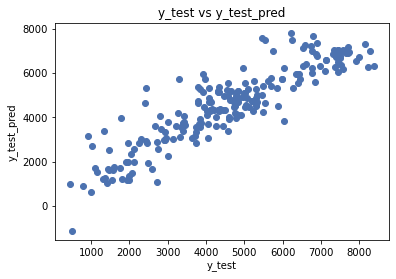

In [50]:
# Plot y_test vs y_test_pred

plt.scatter(y_test, y_test_pred)
plt.title('y_test vs y_test_pred')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')      
plt.show()

### R-squared

In [51]:
print(r2_score(y_test, y_test_pred))

0.8035631653876802


## Conculsion

The final model has following expression:

cnt = 1963.58 + 4071.06 * temp - 1321.15 * windspeed - 709.44 * spring + 666.435 * winter + 338.21 * summer - 654.24 * Mist+Cloudy + 2038.50 * yr - 741.15 * holiday - 2446.46 * Snow+Rain - 239.20 * tuesday

Each coefficient signifies the unit change in y if Xnth variable is changed by Bn coefficient when all other variables are kept constant.

From residual analysis it is clear that following assumptions for Linear Regression are true:
- There is linear relationship between target variable and predictors
- Error terms are normally distributed with mean at 0.
- Error terms are independent of each others as there is no visible pattern.
- Error terms ahave constant variance.

The R-squared value for test prediction is 0.8035 which means 80.35% of the variance in the data can be explained by the model.

Business Understanding:
- According to the model when the temperature is high and its summer or winter season the demand is likely to increase.
- Our model also suggests that demand are inversly proportional to factors such as windspeed, spring(although intuitively the demand should have increased in spring), Misty/Cloudy/Snow/Rain weather, holidays and tuesdays